# Conservation of Cell Cylce effect
Before vs. after integration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scIB

sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
import warnings
warnings.filterwarnings('ignore')

scanpy==1.4.4+40.gbd5f862 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
plt.rcParams['figure.figsize'] = 8,8

In [3]:
adata_file = "/storage/groups/ml01/workspace/group.daniela/MCA_normalised/Lung.h5ad"
adata_file = "/storage/groups/ml01/workspace/group.daniela/tm/facs/norm/Limb_Muscle_raw.h5ad"

In [4]:
adata = sc.read(adata_file, cache=True)

## Visualisation and Clustering

In [5]:
scIB.preprocessing.reduce_data(adata, hvg=True, batch='tissue', pca=True, umap=True)

filtered out 5033 genes that are detectedin less than 1 cells
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

Number of highly variable genes: 4000
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 5 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)


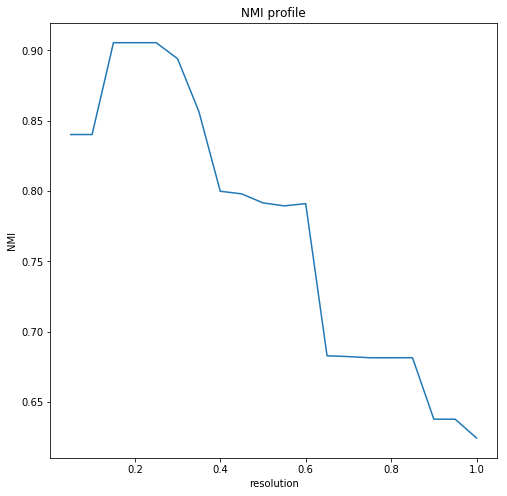

In [6]:
opt_clus = scIB.clustering.opt_louvain(adata, label='cell_type', plot=True)

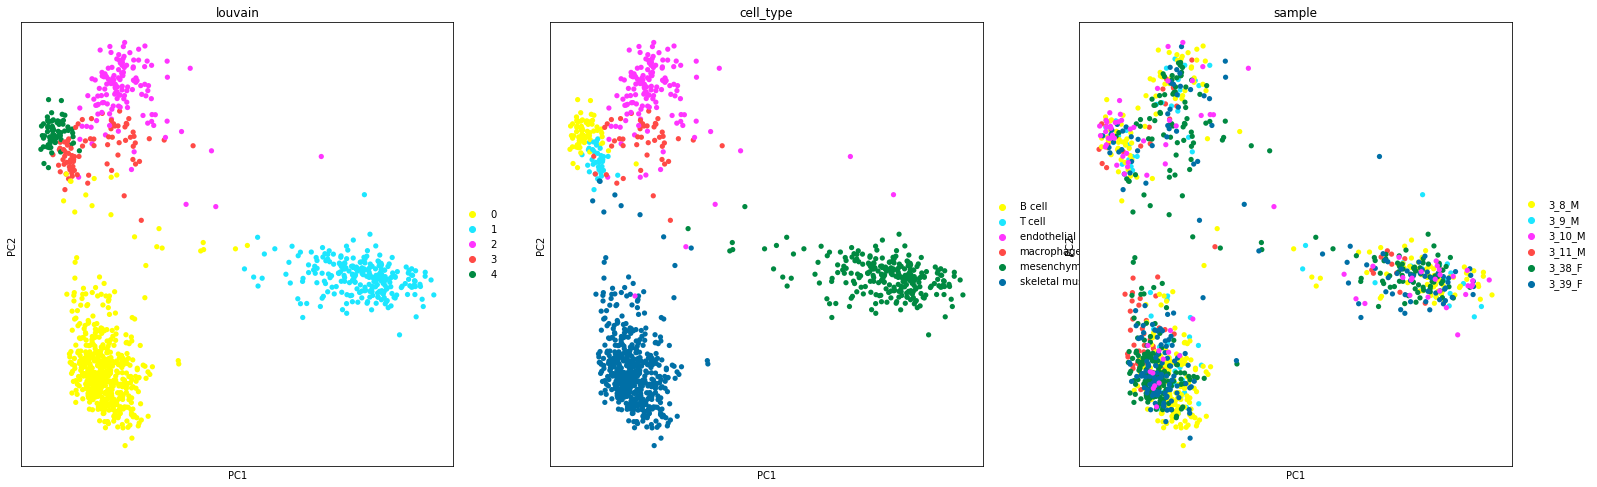

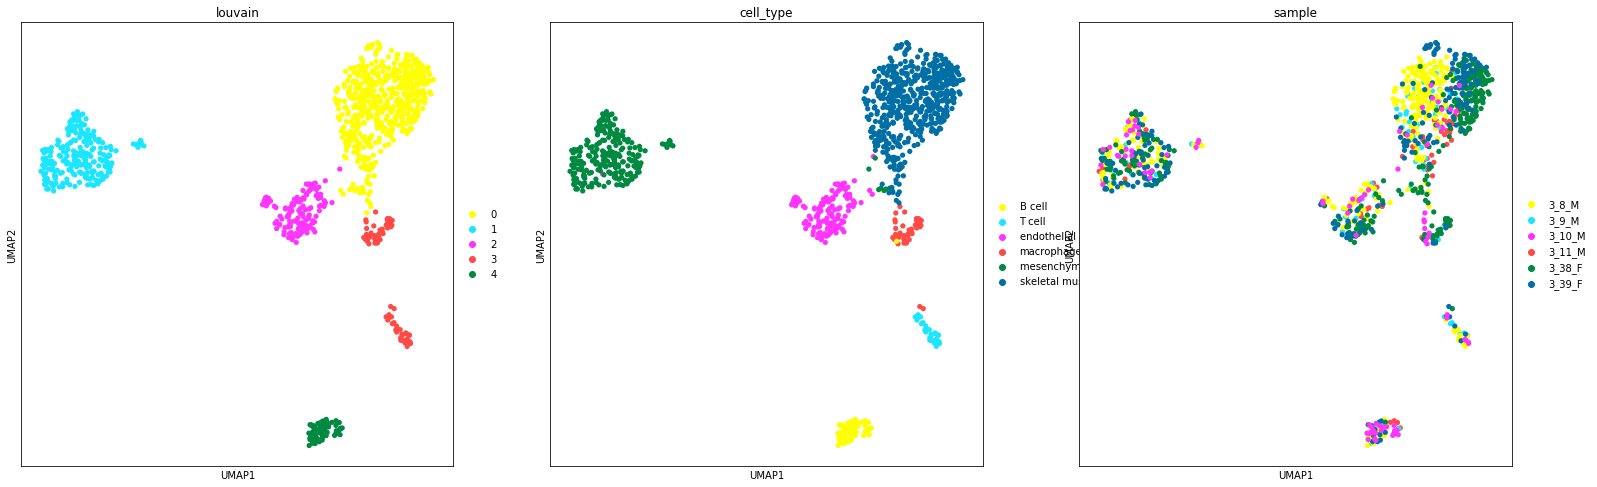

In [7]:
sc.pl.pca(adata, color=['louvain', 'cell_type', 'sample'], palette=sc.pl.palettes.godsnot_64)
sc.pl.umap(adata, color=['louvain', 'cell_type', 'sample'], palette=sc.pl.palettes.godsnot_64)

In [8]:
scIB.metrics.measureTM(
    scIB.metrics.kBET_comparison,
    adata, adata.layers['counts'], adata.X, covariate_key='sample', subsample=None
)

covariate: sample
cluster 1
importing count matrix
kBET estimation
Initial neighbourhood size is set to 10.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.212   0.544   0.053 
Number of kBET tests is set to 26.
No outsiders found.importing count matrix
kBET estimation
Initial neighbourhood size is set to 10.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.373   0.899   0.082 
Number of kBET tests is set to 26.
No outsiders found.cluster 0
importing count matrix
kBET estimation
Initial neighbourhood size is set to 23.
reducing dimensions with svd first...
finding knns...done. Time:
   user  system elapsed 
  0.400   0.991   0.114 
Number of kBET tests is set to 56.
There are 87 cells (15.761%) that do not appear in any neighbourhood.
The expected frequencies for each category have been adapted.
Cell indexes are saved to result list.
importing count matrix
kBET estimation
Initial neighbourhood si

(709.3125,
 82.81301900000015,
 ({'1': -0.8135247424506643,
   '0': -0.619754693287516,
   '2': -0.9622074408431314,
   '4': 0.25053558487331795,
   '3': -0.2603054582116635},))

## Cell cycle effect

### Compute cell cycle scores

Using Tirosh et al. cell cycle marker genes

In [10]:
marker_gene_file = '../data/regev_lab_cell_cycle_genes.txt'

In [11]:
adata.obs.columns

Index(['tissue', 'sample', 'sex', 'cell_type', 'n_counts', 'log_counts',
       'n_genes', 'percent_mito', 'size_factors', 'louvain'],
      dtype='object')

In [12]:
s_genes, g2m_genes = scIB.preprocessing.cc_tirosh(marker_gene_file)
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:01)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


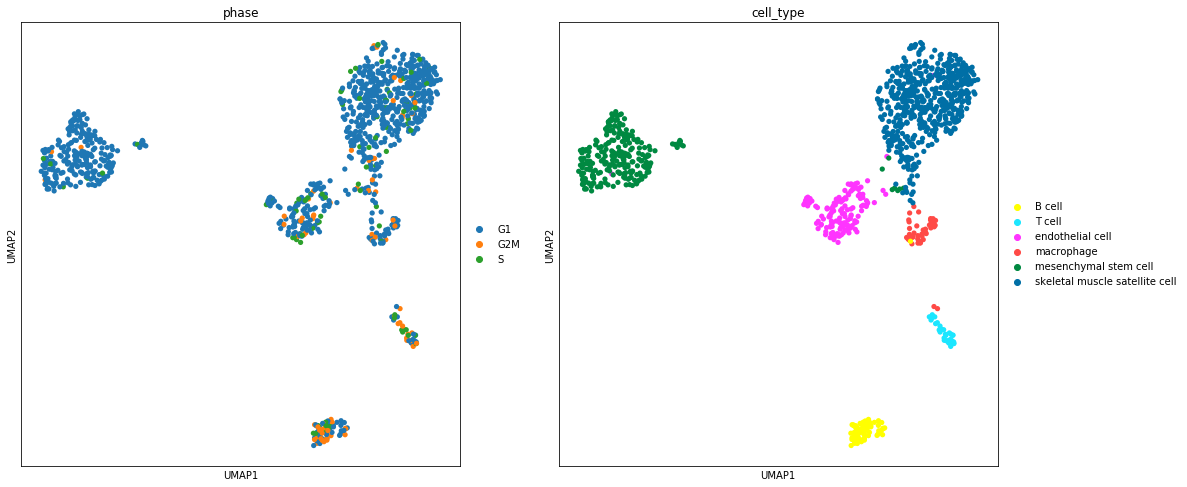

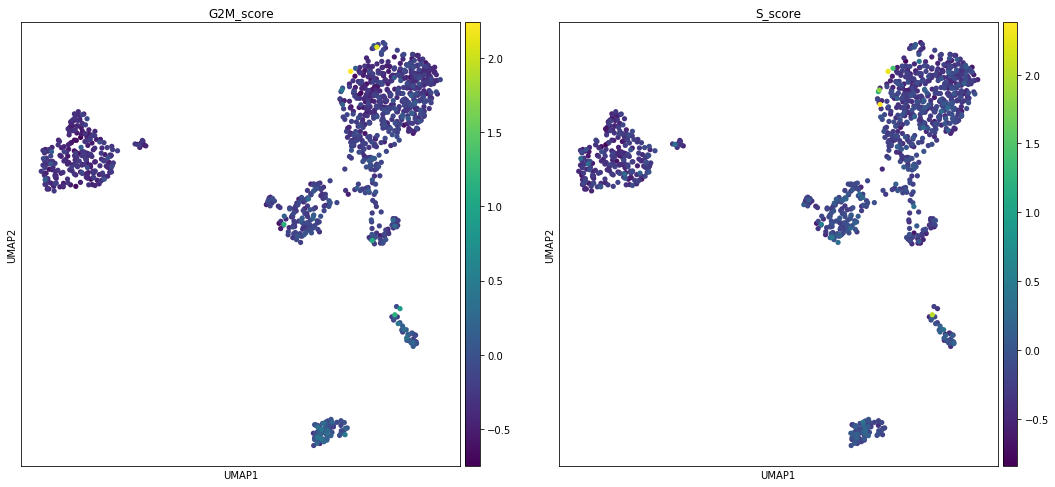

In [13]:
sc.pl.umap(adata, color=['phase', 'cell_type'])
sc.pl.umap(adata, color=['G2M_score', 'S_score'])

### Metrics

In [14]:
scIB.metrics.measureTM(
    scIB.metrics.cell_cycle,
    adata, adata.layers['counts'], adata.X, hvg=False
)

covariate: S_score
matrix dimensions: (1090, 18400)
computing PCA with n_comps = 1090
    finished (0:00:10)
importing data to R
PC regression
matrix dimensions: (1090, 18400)
computing PCA with n_comps = 1090
    finished (0:00:12)
importing data to R
PC regression
covariate: G2M_score
matrix dimensions: (1090, 18400)
computing PCA with n_comps = 1090
    finished (0:00:12)
importing data to R
PC regression
matrix dimensions: (1090, 18400)
computing PCA with n_comps = 1090
    finished (0:00:12)
importing data to R
PC regression
memory usage:477.0 MB
runtime: 87.0 s


(477.12109375, 87.4395019999999, (0.56341189674523,))